In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import  rc

%matplotlib inline 


### Reaction Diffusion equations on a square grid 

FitzHugh Nagumo, Brusellator and Gray-Scott reaction diffusion equation models. 
Also  the heat equation. 
The Laplacian is a second order version that looks like a plus sign.  

\begin{align}
\frac{\partial u({\bf x},t)}{\partial t} & = D_u \Delta u({\bf x},t) + R_u(u,v) \\ 
\frac{\partial v({\bf x},t)}{\partial t} & = D_v \Delta u({\bf x},t) + R_v(u,v) 
\end{align}
where $D_u,D_v$ are diffusion coefficients.  In 2D the Laplacian
$$\Delta = \frac{\partial^2 }{\partial x^2} + \frac{\partial^2 }{\partial y^2}$$ 
The functions $R_u, R_v$ are the reaction equations and are for the different models 
\begin{align}
\begin{array}{lll}
   {\rm FitzHugh-Nagumo:} & R_u(u,v) =  u - u^3 - v + \alpha        &  R_v(u,v) = (u - v)\beta \\
   {\rm Brusselator:}     & R_u(u,v) = \alpha - (\beta+1) u + u^2 v &  R_v(u,v) = \beta u - u^2 v \\
   {\rm Gray-Scott:}      & R_u(u,v) =  -u v^2 + \alpha (1-u)       &  R_v(u,v) =  u v^2 -(\alpha+ \beta)v
    \end{array}
\end{align}

The reaction equations depend upon parameters $\alpha,\beta$.  Sometimes $\alpha$ is called a feed rate and $\beta$ a kill rate. 

Our scheme for updating a Cartesian grid of $u, v$ values is
\begin{align}
u^{n+1}_{i,j}  &= u^n_{i,j} + D_u \frac{\Delta t}{\Delta x^2} \left( u_{i,j+1}^n  + u_{i,j-1}^n  + u_{i+1,j}^n  + u_{i-1,j}^n - 4 u_{i,j}^n \right) + \Delta t R_u(u_{i,j}^n, v_{i,j}^n) \\
v^{n+1}_{i,j}  &= v^n_{i,j} + D_v \frac{\Delta t}{\Delta x^2} \left( v_{i,j+1}^n  + v_{i,j-1}^n  + v_{i+1,j}^n  + v_{i-1,j}^n - 4 v_{i,j}^n \right) + \Delta t R_v(u_{i,j}^n, v_{i,j}^n) 
\end{align}
Where indices $i,j$ refer to spatial indices of our 2d Cartesian grid and $n$ refers to the time. 
The timestep is $\Delta t$ and the spacing on the Cartesian grid is $\Delta x$. 

In [17]:
# Laplacian operator operated on 2d array a, and with periodic boundary conditions 
# dx is grid spacing, a is a 2d array
# roll shifts array by 1, in i or j directions 
# return result as an array
def laplacian2D(a, dx):
    return (- 4*a + np.roll(a,1,axis=0) + np.roll(a,-1,axis=0)\
            + np.roll(a,+1,axis=1) + np.roll(a,-1,axis=1)) / (dx**2)
 
# Reaction parts of differential equations for 
# three different types of different Reaction diffusion equations
# u,v are 2D arrays or fields, alpha, beta could be numbers or arrays or fields
# rdtype is a string specifying the model
def Reaction(u,v,alpha,beta,rdtype):
    if (rdtype == 'FN'):  # FitzHugh Nagumo model
        Ru,Rv=R_FN(u,v,alpha,beta)
        return Ru,Rv
    if (rdtype == 'Br'):  # Brusellator model
        Ru,Rv= R_Br(u,v,alpha,beta)
        return Ru,Rv
    if (rdtype == 'GS'):  # Gray-Scott model
        Ru,Rv = R_GS(u,v,alpha,beta)
        return Ru,Rv
    if (rdtype=='Heat'):
        Ru = u*0.0; Rv = v*0.0;
        return Ru,Rv
    print('invalid reaction type')

#The FitzHugh-Nagumo Reaction Diffusion Model
# examples: Du, Dv, alpha, beta = 1, 100, 0.5, 20, dt=0.0002, dx=1
def R_FN(u,v,alpha,beta): 
    Ru =  u - u**3 - v + alpha 
    Rv = (u - v)*beta
    return Ru,Rv
    
# Brusselator Reaction Diffusion model
# example: Du, Dv, alpha, beta = 2, 22, 5, 9 # dt=0.005, dx=1
def R_Br(u,v,alpha,beta): 
    Ru = alpha - (beta+1)*u + (u**2)*v 
    Rv = beta*u - (u**2)*v
    return Ru,Rv

# The Gray-Scott Reaction Diffusion model
# alpha is feed rate for u,  alpha kills v, beta kills v
# example: Du = 0.2, Dv = Du/2, alpha = 0.037 and beta = 0.06 , dx=1
def R_GS(u,v,alpha,beta): 
    Ru =  -u*(v**2) + alpha*(1-u) 
    Rv =  u*(v**2) -(alpha+ beta)*v
    return Ru, Rv


In [209]:
# a class for initializing and computing and showing solutions to 
# a 2D reaction diffusion equation
# in this version I show both u,v images
class Update_RD(object):
    # do this when creating a class object, axis info is passed, 
    # along with parameters for the reaction diffusion equation
    def __init__(self, alpha=5.0,beta=9.0,Du=2.,Dv=22.,\
                 n=100,dt=0.005,dx=1,rdtype='Br',nsteps=1,\
                 Lap_fun=laplacian2D):
        self.success = 0
        self.alpha = alpha  # parameter for reaction
        self.beta = beta  # parameter for reaction
        self.Du = Du  # diffusion coefficient for u
        self.Dv = Dv  # diffusion coefficient for v
        self.n = n    # dimension of u,v arrays
        self.rdtype = rdtype  # type of reaction diffusion model, is a string
        
        self.dx = dx   # horizontal grid spacing
        self.dt = dt   # timestep
        self.nsteps = nsteps  # how many timesteps to take per display and per update
        self.Lap_fun = Lap_fun   # which Laplacian operator to use
        
        # initial conditions for u,v arrays
        # I find that the Gray-Scott model needs these types of initial conditions
        if (rdtype=='GS'):
            self.u = np.zeros((n,n)) + 1.0
            self.v = np.zeros((n,n)) 
            for k in range(0,int(n/10)):
                i = int(n*np.random.rand())  # randomly chose locations to set
                j = int(n*np.random.rand())
                self.v[i,j]=np.random.rand()  # set to number in [0,1)
        if (rdtype=='FN'):
            self.u = 0.05*np.random.rand(n, n)  # initial u data uniform distribution
            self.v = 0.05*np.random.rand(n, n)  # initial v data
            
        else:  # whereas Brusellator and FitzhughNagumo models seem to work with random, 
            #  near zero initial conditions
            self.u = 0.05*np.random.rand(n, n)  # initial u data uniform distribution
            self.v = 0.05*np.random.rand(n, n)  # initial v data
        
        fac_u=  self.Du*self.dt/self.dx**2  # relevant for checking cfl condition
        fac_v=  self.Dv*self.dt/self.dx**2  
        if (fac_u>1):
            print('cfl warning Du', fac_u)
        if (fac_v>1):
            print('cfl warning Dv', fac_v)
        print(fac_u,fac_v)
    
    def update_nsteps(self):
    # do nsteps,  update u,v arrays
        for ii in range(self.nsteps):
            # compute diffusive terms, with Laplacian of your choice!
            du = self.Du*self.Lap_fun(self.u, self.dx)  
            dv = self.Dv*self.Lap_fun(self.v, self.dx)
            # compute reation terms
            Ru,Rv = Reaction(self.u,self.v,self.alpha,self.beta,self.rdtype)        
            # update u,v arrays
            self.u = self.u + (du + Ru)*self.dt
            self.v = self.v + (dv + Rv)*self.dt

    # experiment with different boundaries in this routine to update the arrays
    def update_nsteps_with_boundary(self):
    # do nsteps,  update u,v arrays
        for ii in range(self.nsteps):
            # compute diffusive terms, with Laplacian of your choice!
            du = self.Du*self.Lap_fun(self.u, self.dx)  
            dv = self.Dv*self.Lap_fun(self.v, self.dx)
            # compute reation terms
            Ru,Rv = Reaction(self.u,self.v,self.alpha,self.beta,self.rdtype)  

            # playing with top and bottom boundaries, these are fixed boundaries
            #du[0,:] = 0; Ru[0,:]=0.0; dv[0,:] = 0; Rv[0,:]=0.0 
            #du[-1,:] = 0; Ru[-1,:]=0.0; dv[-1,:] = 0; Rv[-1,:]=0.0 

            # update u,v arrays
            self.u = self.u + (du + Ru)*self.dt
            self.v = self.v + (dv + Rv)*self.dt
            
            # this type of boundary sets normal gradient to zero on top and bottom 
            self.u[0,:] = self.u[1,:];  self.u[-1,:] = self.u[-2,:]
            self.v[0,:] = self.v[1,:];  self.v[-1,:] = self.v[-2,:]
            
    def return_uv(self):
        return self.u,self.v


# display fields u, v
# u[i,j] index i is in y direction, index j is in x direction by convention here
def show_uv(u,v,dx):
    fig, ax = plt.subplots(1,2,figsize=(8,5),sharex=True,sharey=True)
    ax[0].set_aspect('equal')
    ax[1].set_aspect('equal')
    nx = u.shape[0]; ny = u.shape[1]
    ext = [0,(nx-1)*dx, 0,(ny-1)*dx]
    im0=ax[0].imshow(u,cmap='jet',extent=ext)
    im1=ax[1].imshow(v,cmap='hsv',extent=ext)
    plt.colorbar(im0,location='top')
    plt.colorbar(im1,location='top')

0.008 0.088


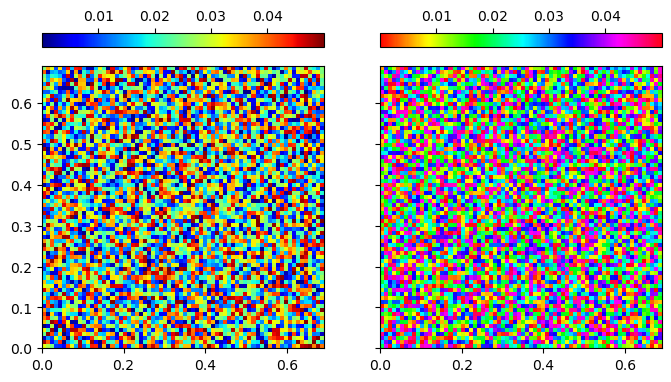

In [215]:
# set up the Brusselator model with some nice parameters

fac = 0.01; dx= fac
ud_Br = Update_RD(alpha=5.0,beta=9.0,Du=2*fac**2,Dv=22*fac**2,\
                 n=70,dt=0.004,dx=fac,rdtype='Br',nsteps=400)
            
u, v = ud_Br.return_uv()
#u[0,:]+=0.5
show_uv(u,v,dx)


/var/folders/l_/tk7gphlj0d38754sb6x8p1f00000gn/T/ipykernel_95032/3943224612.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,2,figsize=(8,5),sharex=True,sharey=True)


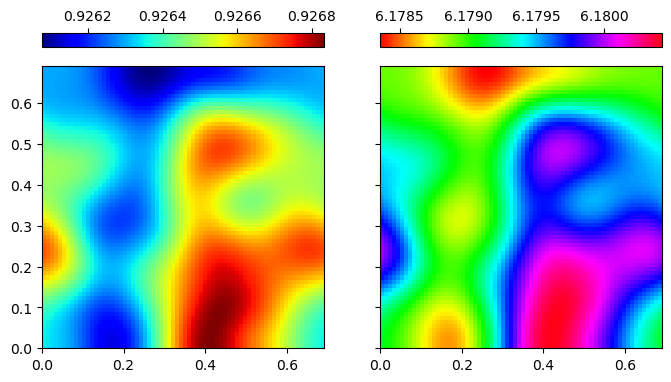

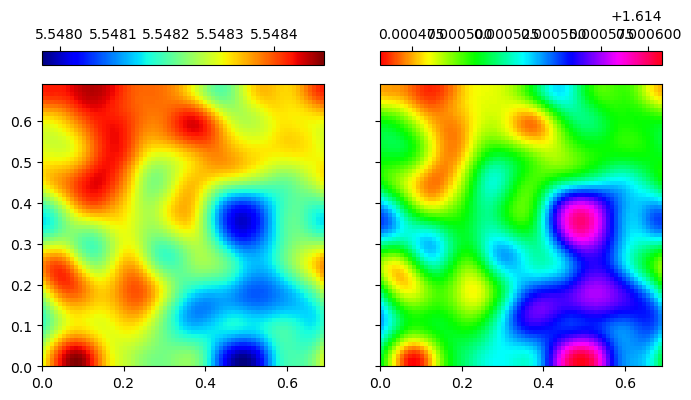

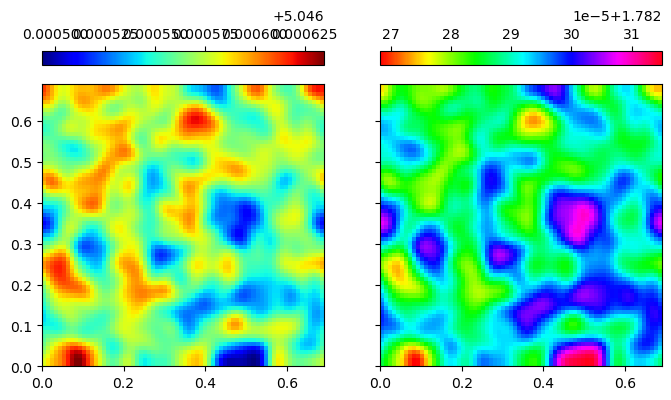

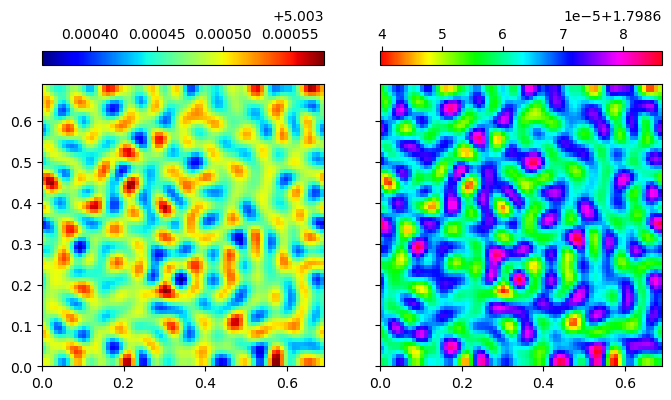

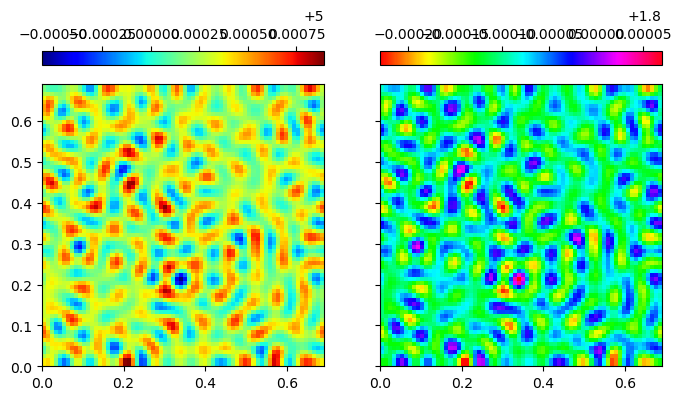

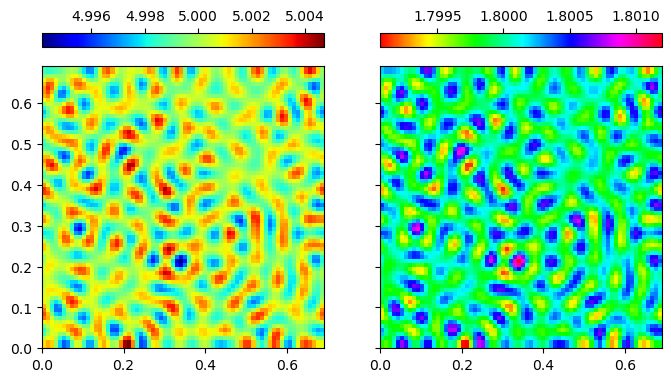

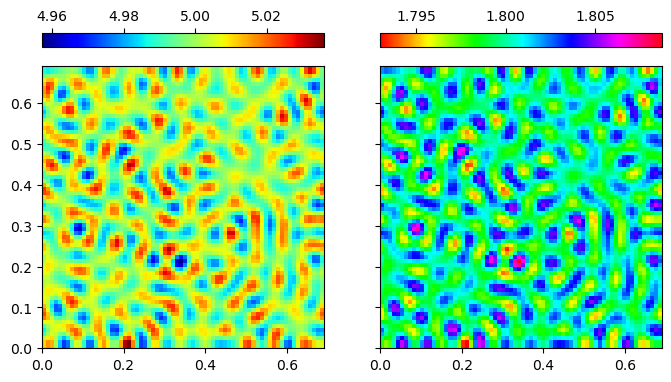

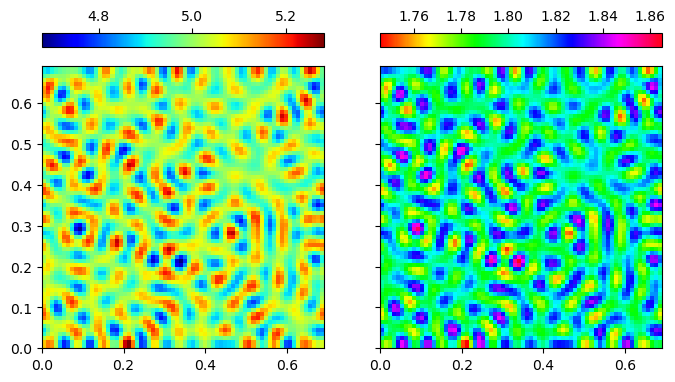

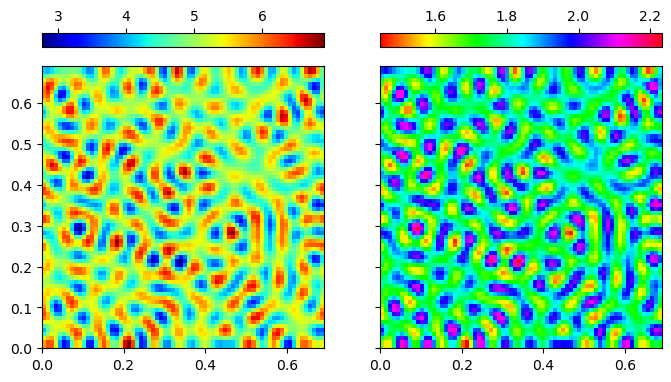

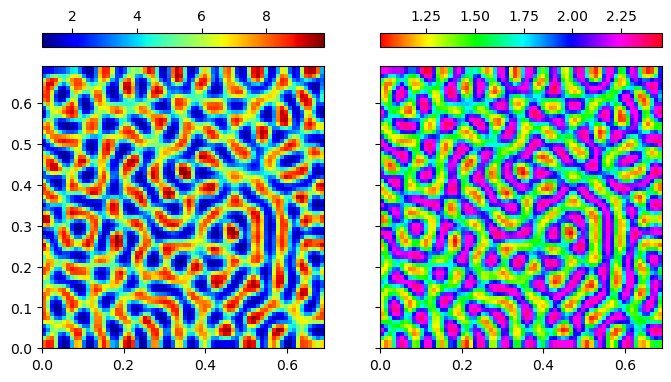

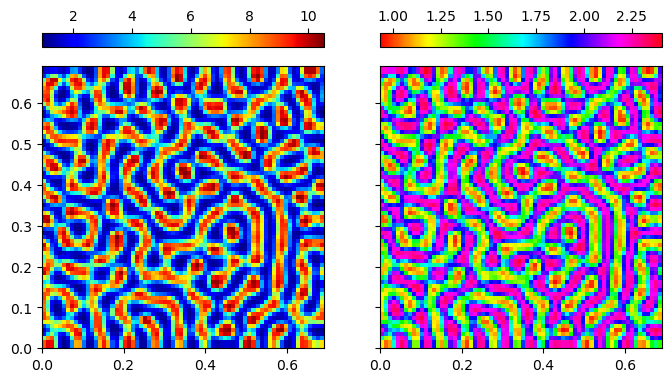

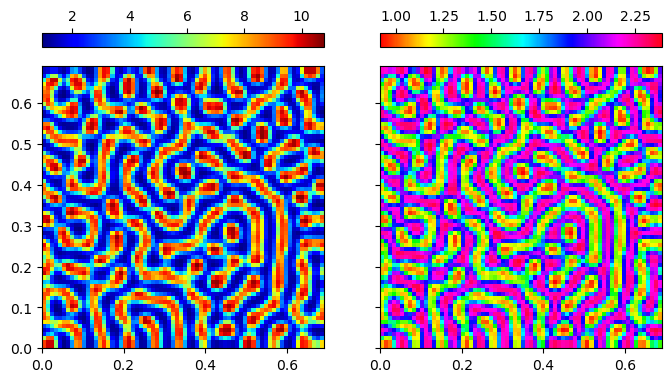

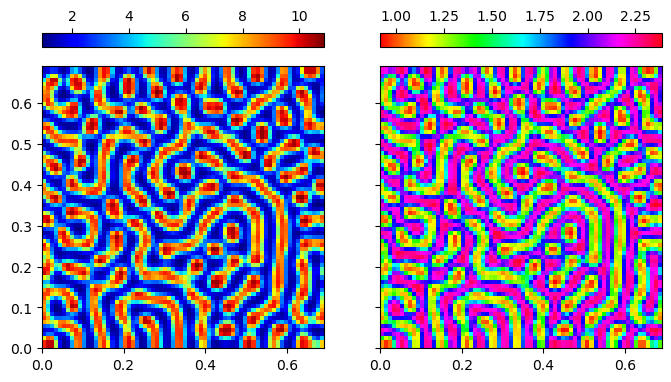

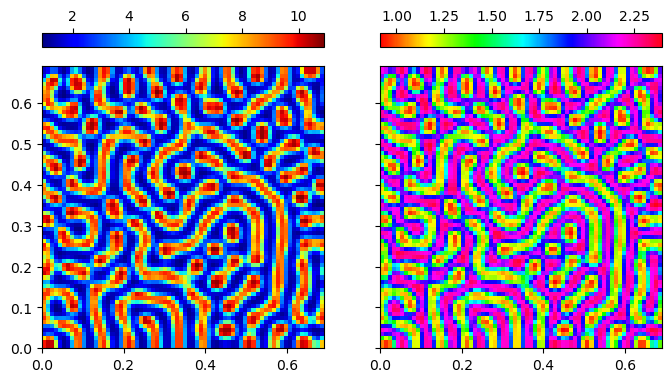

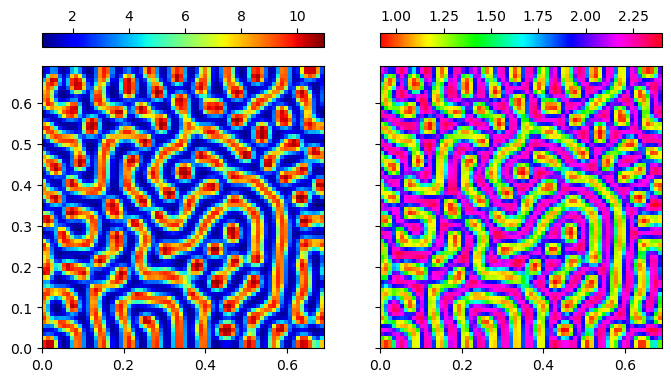

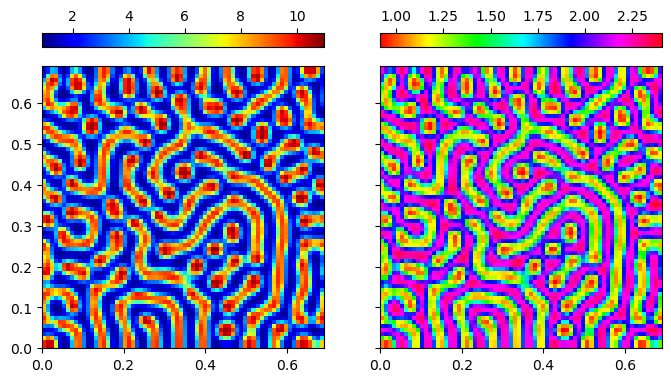

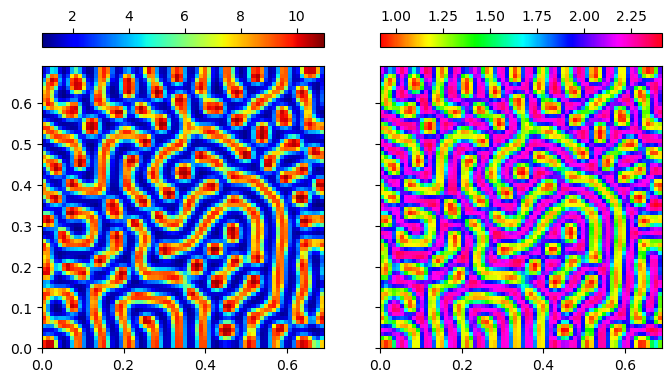

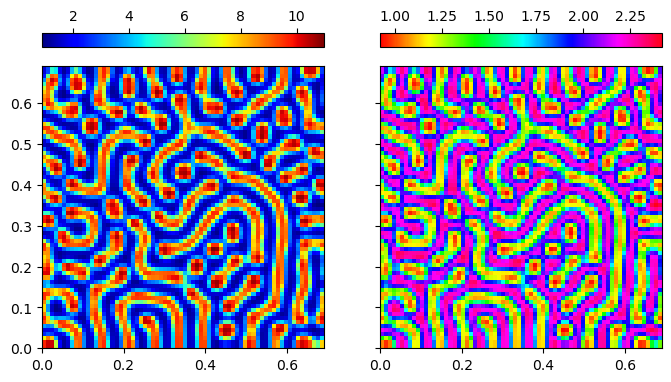

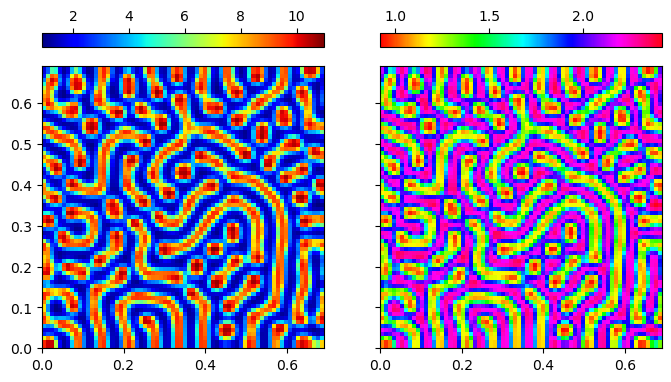

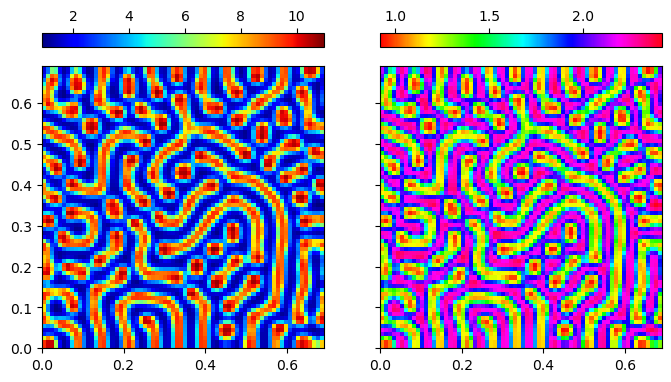

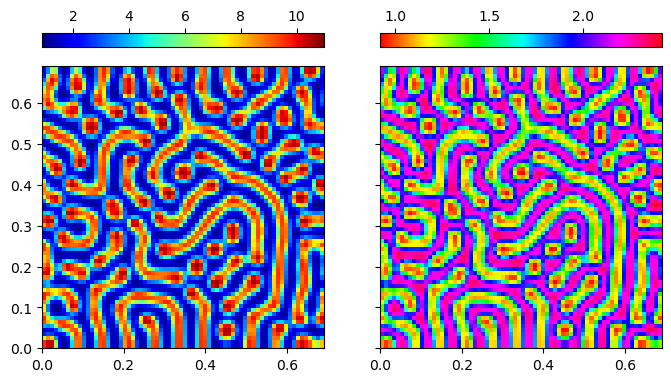

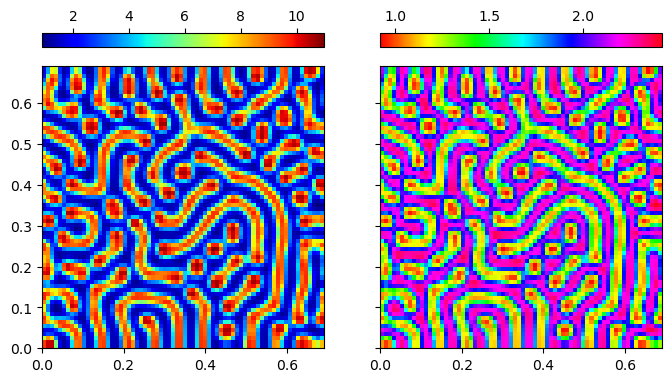

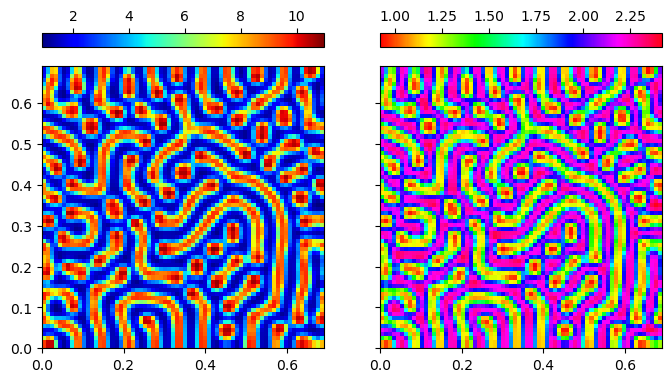

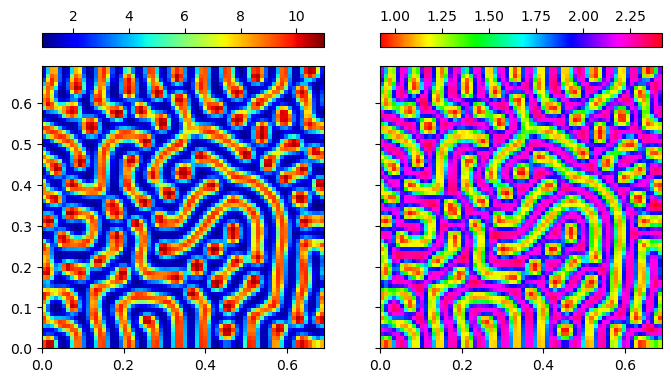

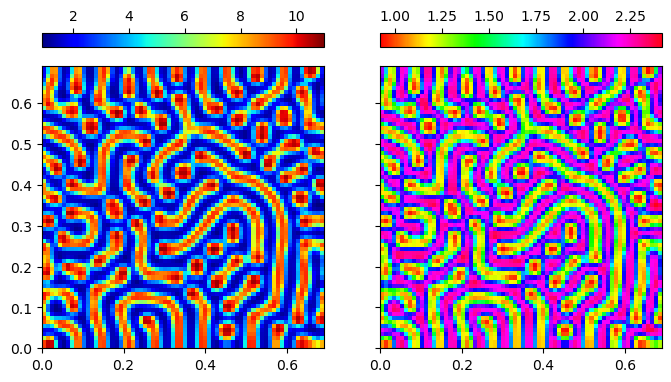

In [217]:
for i in range(25):
    ud_Br.update_nsteps_with_boundary()
    u, v = ud_Br.return_uv()
    show_uv(u,v,dx)

0.005000000000000001 0.05


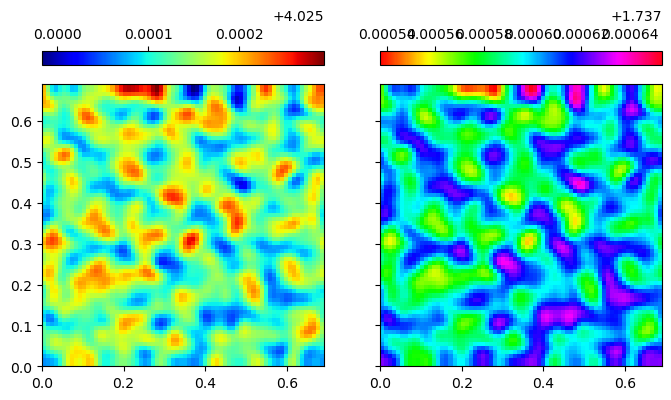

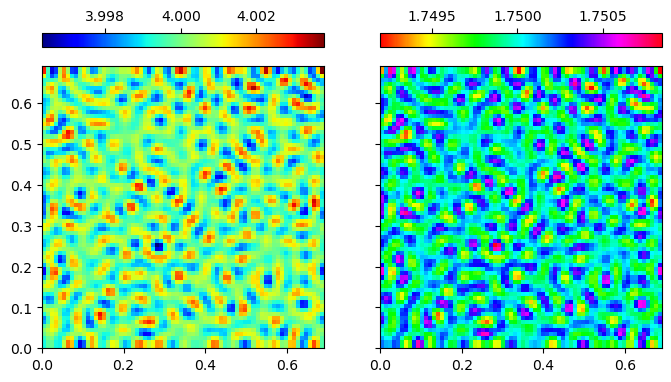

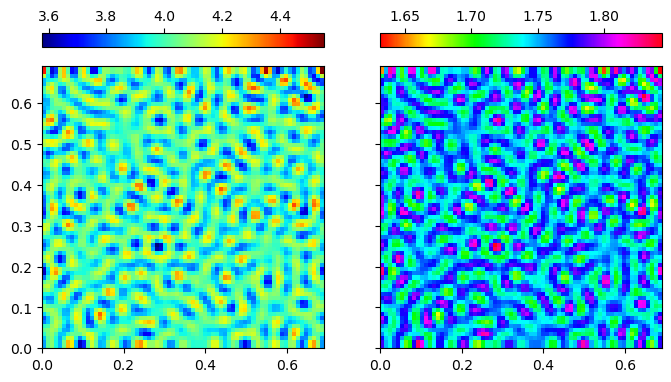

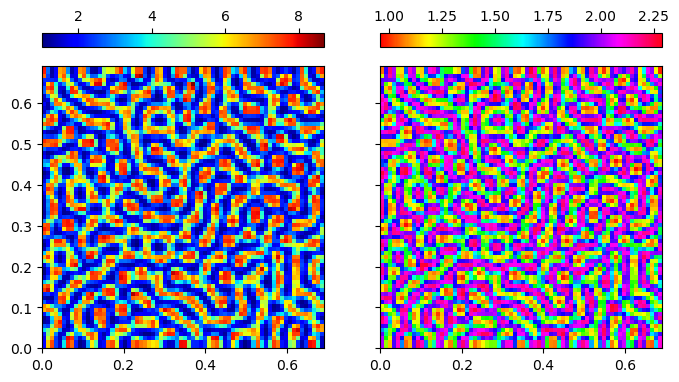

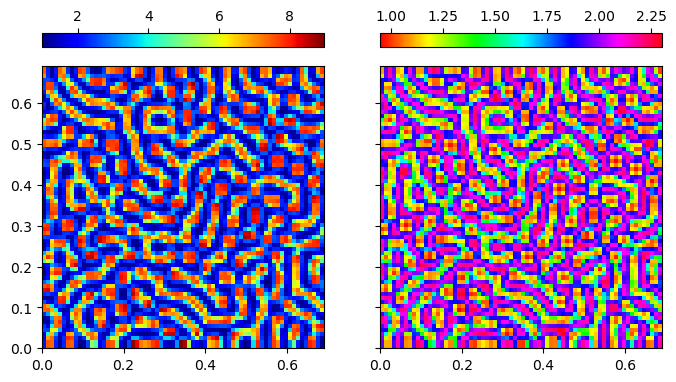

In [290]:
# set up the Brusselator model with some nice parameters

fac = 0.01; dx= fac
ud_Br = Update_RD(alpha=4.0,beta=7.0,Du=1*fac**2,Dv=10*fac**2,\
                 n=70,dt=0.005,dx=fac,rdtype='Br',nsteps=1000)
u, v = ud_Br.return_uv()
#show_uv(u,v,dx)
for i in range(5):
    ud_Br.update_nsteps_with_boundary()
    u, v = ud_Br.return_uv()
    show_uv(u,v,dx)

0.00019999999999999998 0.020000000000000004


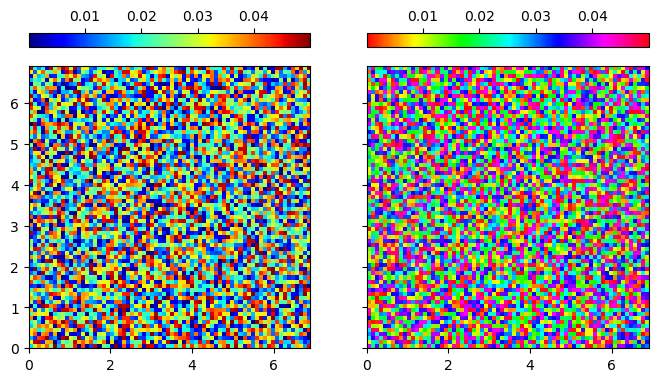

In [211]:
# set up the FN model with some nice parameters

fac = 0.1; dx= fac
ud_FN = Update_RD(alpha=0.5,beta=20.0,Du=1*fac**2,Dv=100*fac**2,\
                 n=70,dt=0.0002,dx=fac,rdtype='FN',nsteps=400)
            
u, v = ud_FN.return_uv()
#u[0,:]+=0.5
show_uv(u,v,dx)

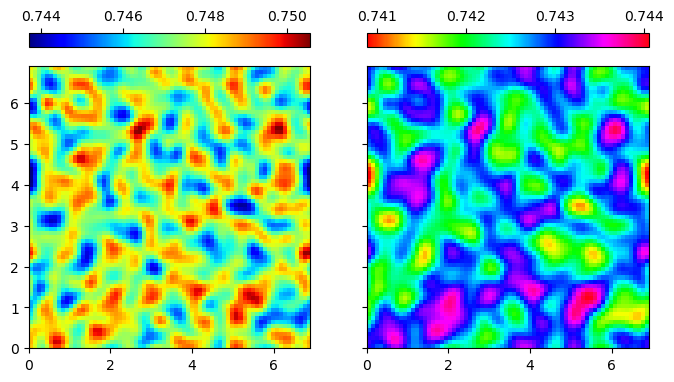

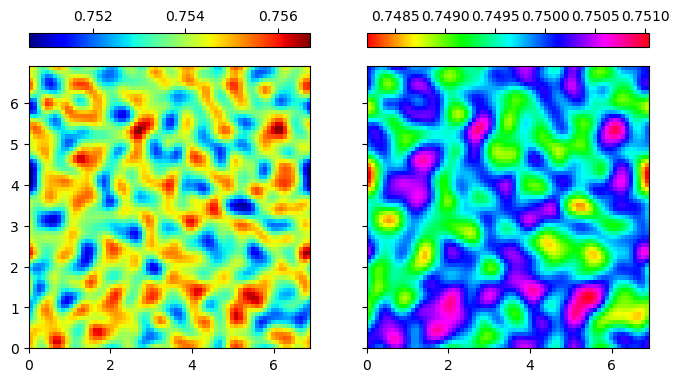

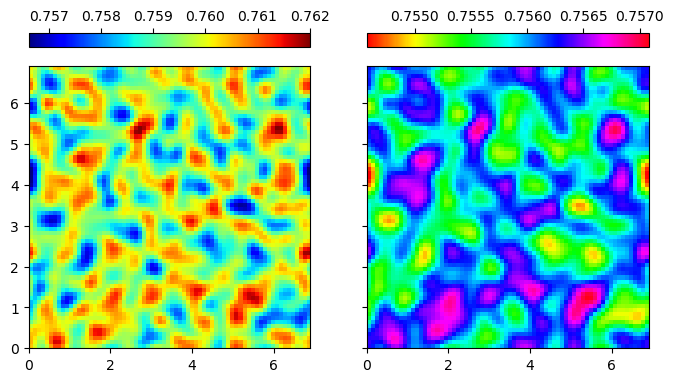

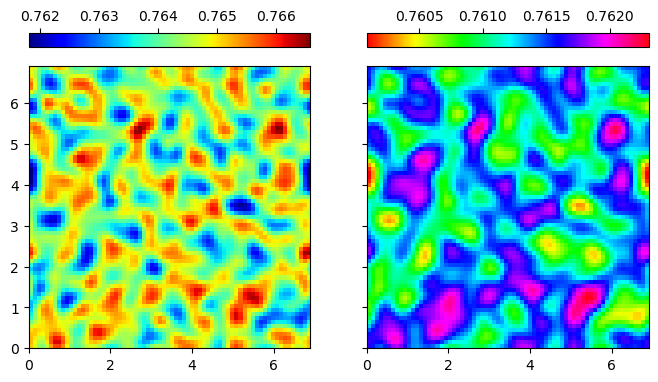

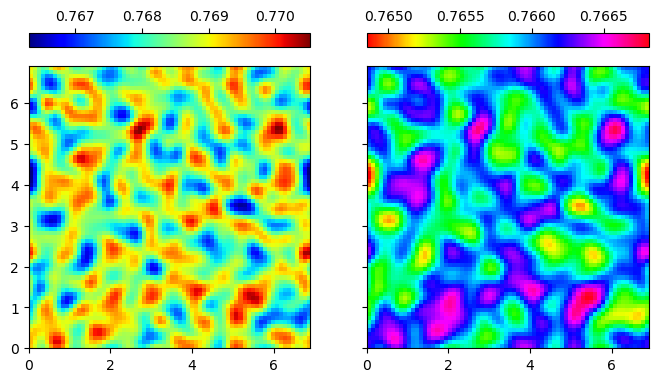

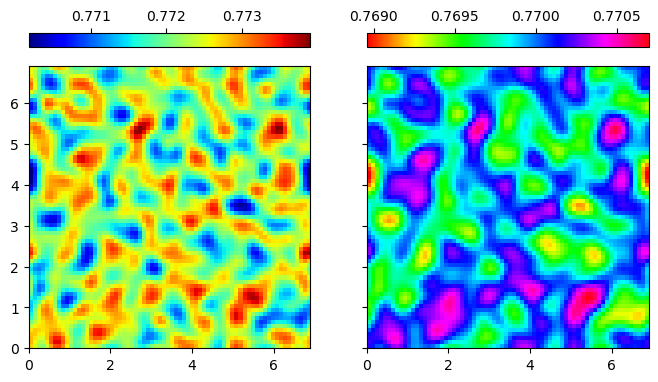

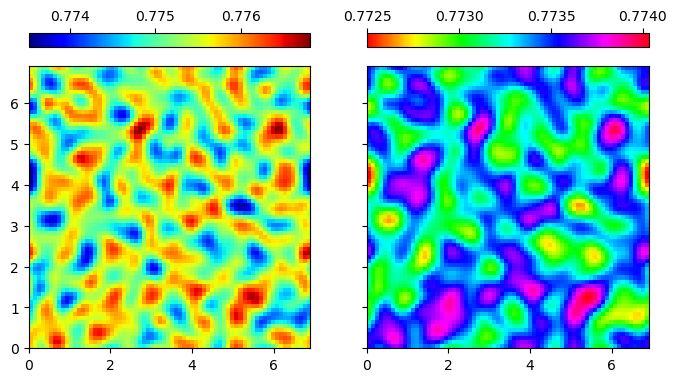

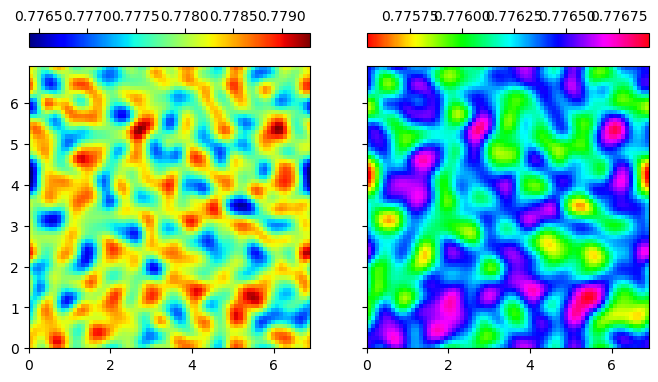

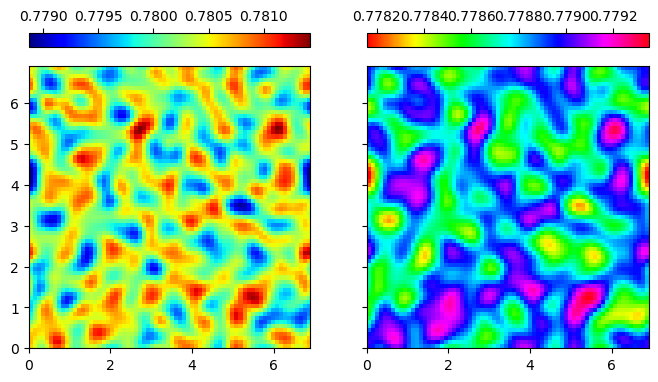

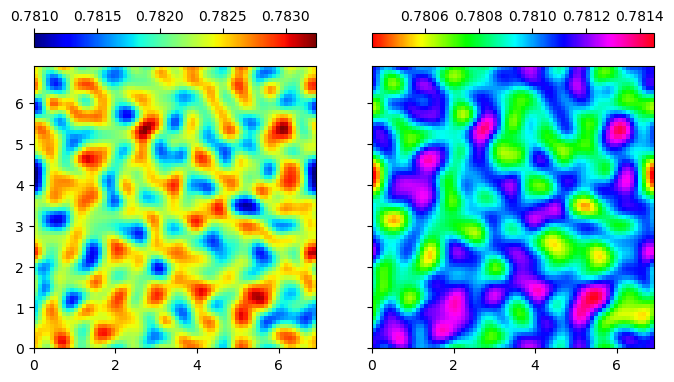

In [205]:
for i in range(10):
    ud_FN.update_nsteps()
    u, v = ud_FN.return_uv()
    show_uv(u,v,dx)

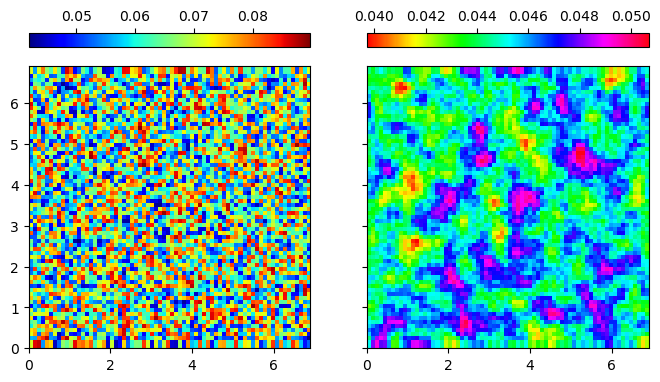

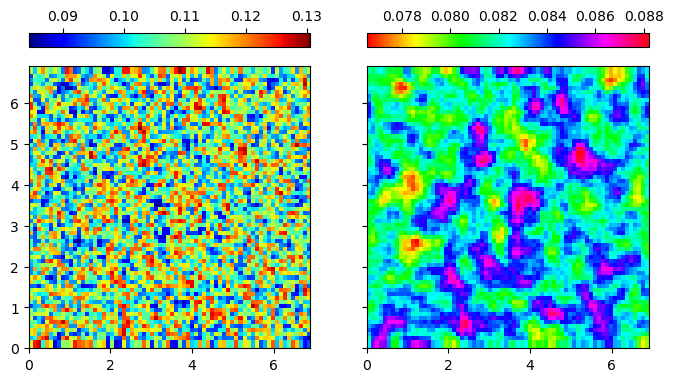

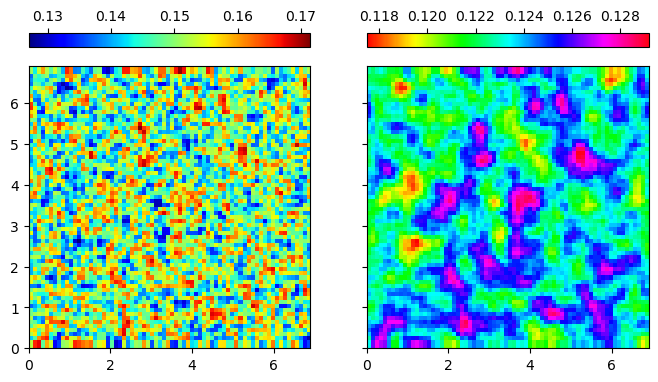

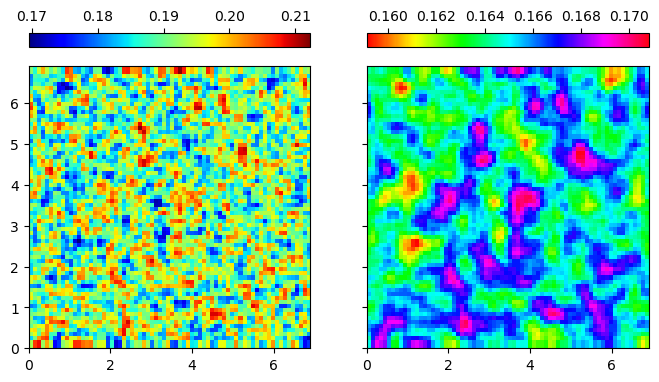

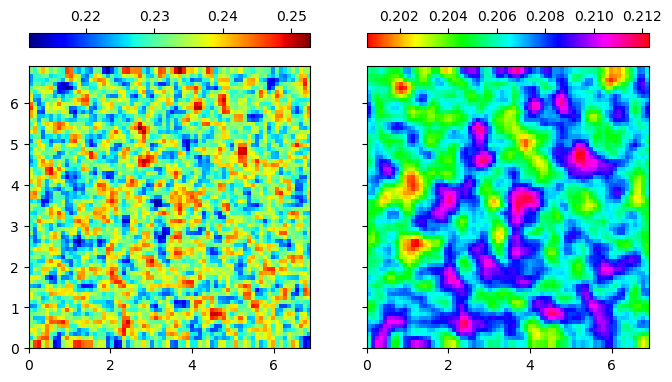

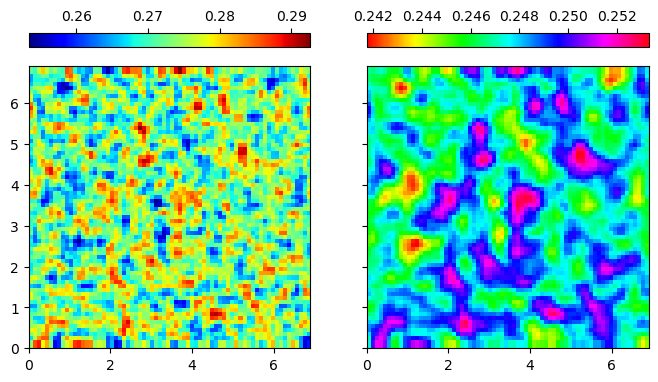

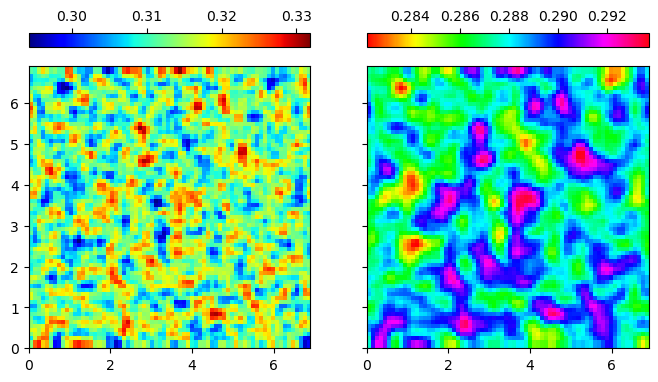

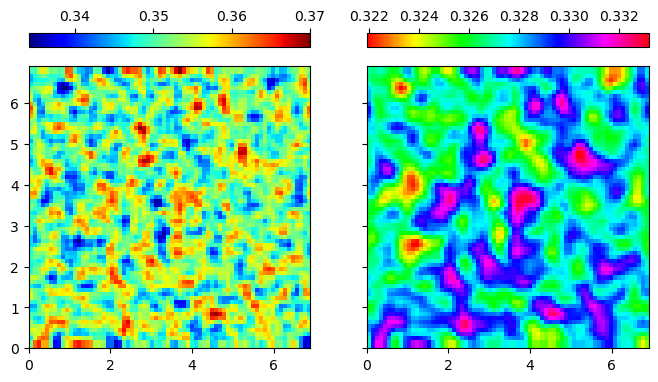

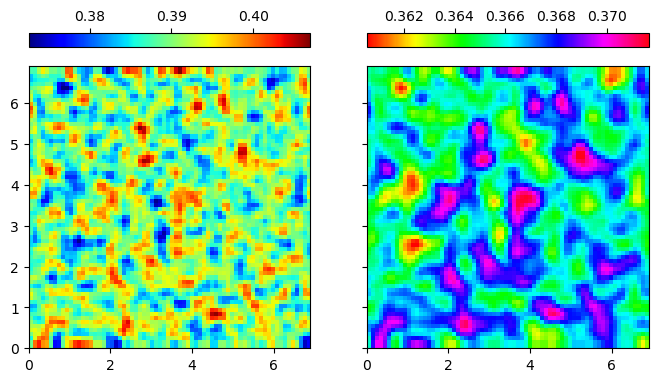

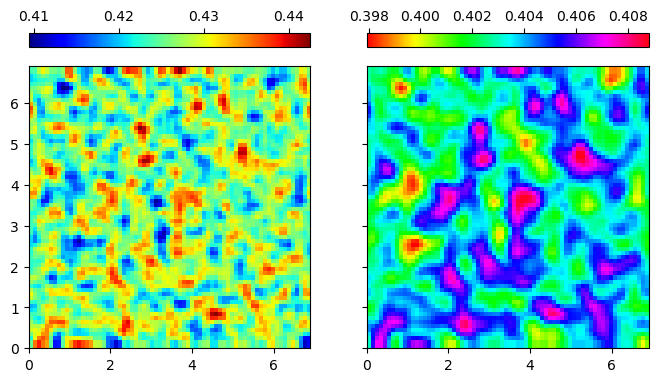

In [213]:
for i in range(10):
    ud_FN.update_nsteps_with_boundary()
    u, v = ud_FN.return_uv()
    show_uv(u,v,dx)

0.24 0.12


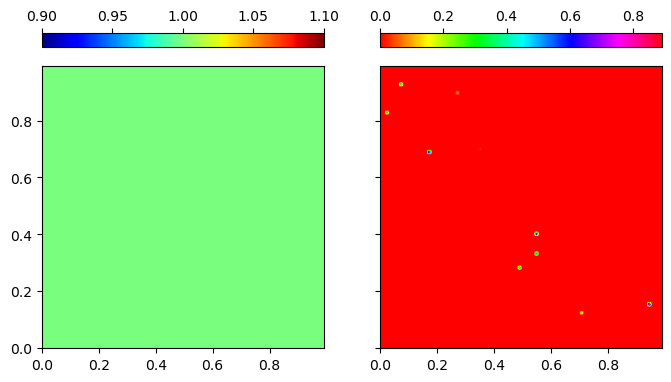

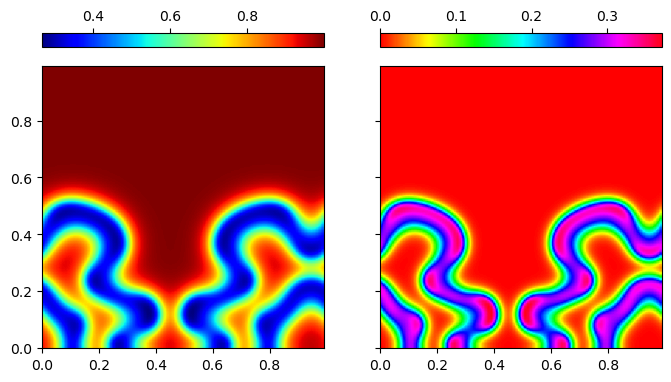

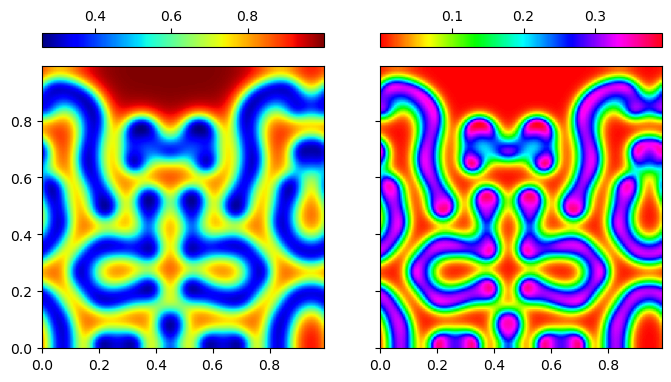

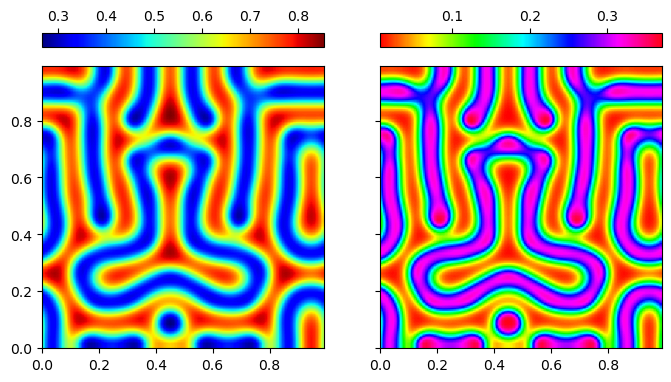

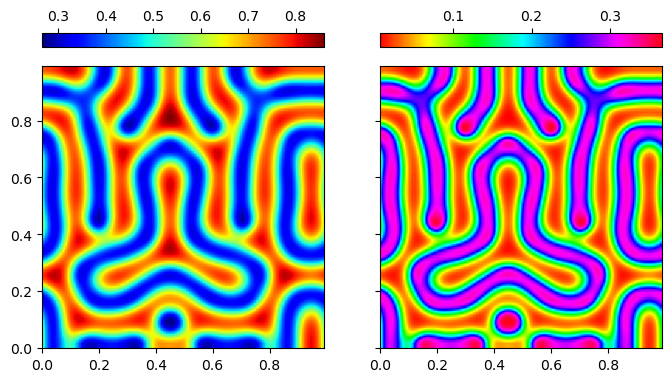

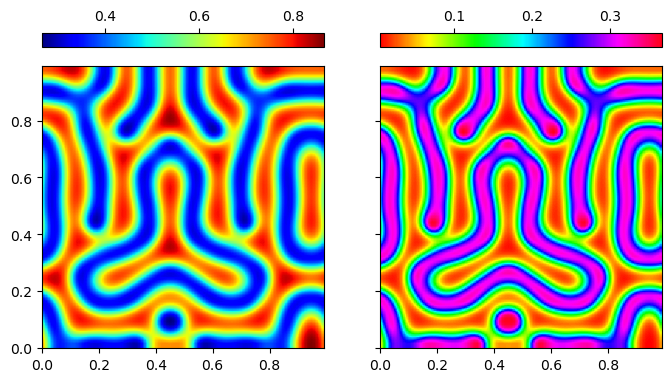

In [302]:
# set up the GS model with some nice parameters

fac = 0.01; dx= fac
ud_GS = Update_RD(alpha=0.035,beta=0.06,Du=0.3*fac**2,Dv=0.15*fac**2,\
                 n=100,dt=0.8,dx=fac,rdtype='GS',nsteps=2000)
            
u, v = ud_GS.return_uv()
show_uv(u,v,dx)
for i in range(5):
    ud_GS.update_nsteps_with_boundary()
    u, v = ud_GS.return_uv()
    show_uv(u,v,dx)

###  floating boundaries seem to work fine!